Logistische Regression zur Vorhersage eines Ausfall innerhalb der nächsten 20 Messperioden

Model soll die folgende Frage beantworten: Kommt es innerhalb der nächsten 20 Messperioden zu einem Ausfall?

Model nutzt für die Vorhersage die Temperatur und die Leistungsaufnahme

In [17]:
# Daten einlesen

%matplotlib inline
import pymssql
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib

conn = pymssql.connect("pcs.f4.htw-berlin.de",
                       "Masterprojekt", "Masterprojekt", "PraediktiveAnalysenTest")
cursor = conn.cursor()

df = pd.read_sql('SELECT * FROM Maschinendaten_20181206', conn)
conn.close()

# unnötige Spalten entfernen
df.pop('Timestamp')
df.pop('Produktionsprogramm')
df.pop('SollMenge')
df.pop('IstMenge')
df.pop('Ausschuss')
df.pop('Machine_ID')
df.pop('Maschine')
df.pop('Datum')
df.pop('Uhrzeit')
df.pop('ID')

# umgekehrt sortieren
df = df.sort_index(ascending=False)


In [18]:
# Kopie anlegen
df_f = df

# Datensätze filtern nach ... und in neuer Variable speichern df_f f=gefiltert
# ... ungeplanten Stillständen (Zufallsfehler)
df_f = df_f.query('FehlerID != "A000"')
df_f = df_f.query('FehlerID != "A001"')
df_f = df_f.query('FehlerID != "A002"')
df_f = df_f.query('FehlerID != "A003"')
df_f = df_f.query('FehlerID != "A004"')
# FehlerID durchsuchen und Zähler anlegen, der angibt wie lang es bis zu nächsten Ausfall dauert
x = []
y = 0
for row in df_f['FehlerID']:
    if row == "x000":
        y += 1
        x.append(y)
    else:
        y = 0
        x.append(y)
# "Ausfallentfernung" an df_s anhängen
df_f['NaechsterAusfall'] = x
        
# Nächste FehlerID durchsuchen, neue Spalte mit Nächster FehlerID (nF001) erzeugen
x = []
y = "NaN"
for row in df_f['FehlerID']:
    if row == "F001":
        y = "F001"
    elif row == "F002":
        y = "F002"
    else:
        y = y
    x.append(y)
# Fehler ID entfernen
df_f.pop('FehlerID')
# "Nächster FehlerID" an df_s anhängen und in zwei Spalten aufsplitten
df_f['nFail'] = x
df_f = df_f.query('nFail != "NaN"')
df_f = pd.get_dummies(df_f[['Drehzahl','Leistungsaufnahme','Vibration','Lautstaerke','Temperatur','NaechsterAusfall','nFail']])

# Nächster Ausfall in 20/50 Schritten
df_f['nA20'] = df_f['NaechsterAusfall'] < 20
df_f['nA50'] = df_f['NaechsterAusfall'] < 50

len(df_f)

8511

In [19]:
# unnötige Zeilen entfernen
df_f = df_f
df_f = df_f.query('Leistungsaufnahme > 15')
df_f = df_f.query('NaechsterAusfall < 100')
#df_f = df_f.query('Temperatur > 99')
len(df_f)

5030

In [20]:
# Model anhand 75 % der Daten erstellen
from sklearn.model_selection import train_test_split
X = df_f[["Temperatur", "Leistungsaufnahme"]].values
y = df_f["nA20"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [21]:
# Modeldaten skalieren, um sie für die lineare Regression nutzbar zu machen
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

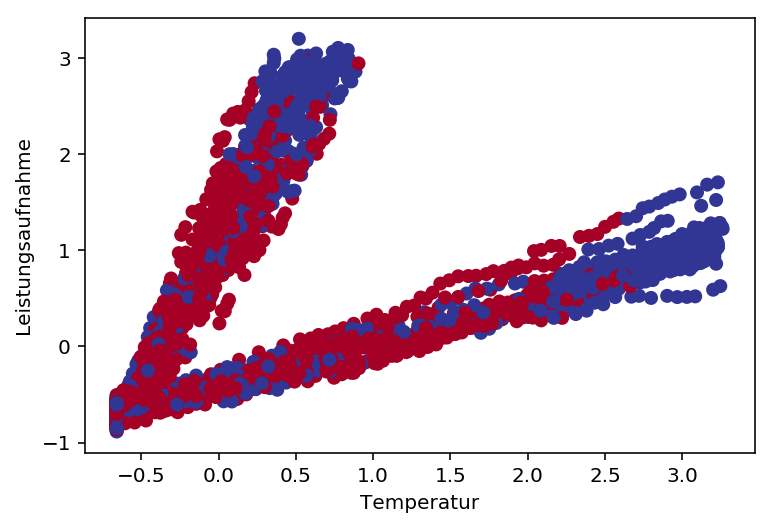

In [22]:
# Modeldaten plotten
plt.scatter(X_train[:,0], X_train[:,1],c = y_train)
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()

In [23]:
# Logistisches Regressionsmodel erstellen
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

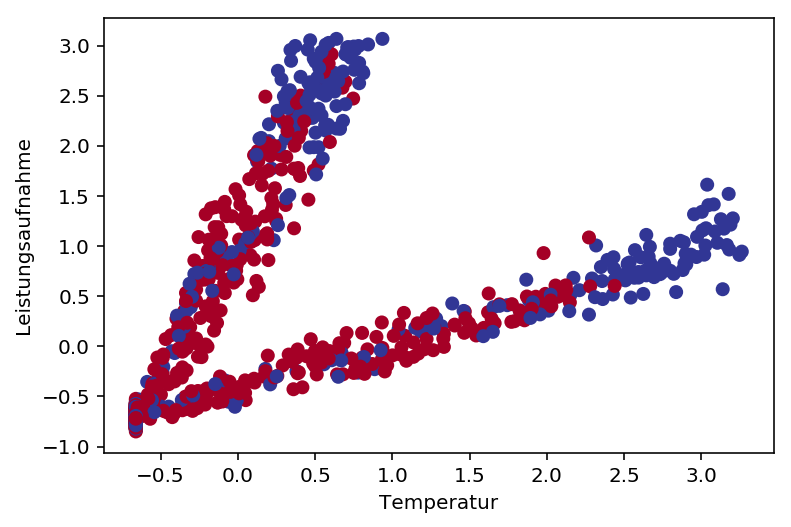

In [24]:
# Test-Modeldaten plotten, Farbwerte = echte nA20 Werte
plt.scatter(X_test[:,0], X_test[:,1], c= y_test)
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()

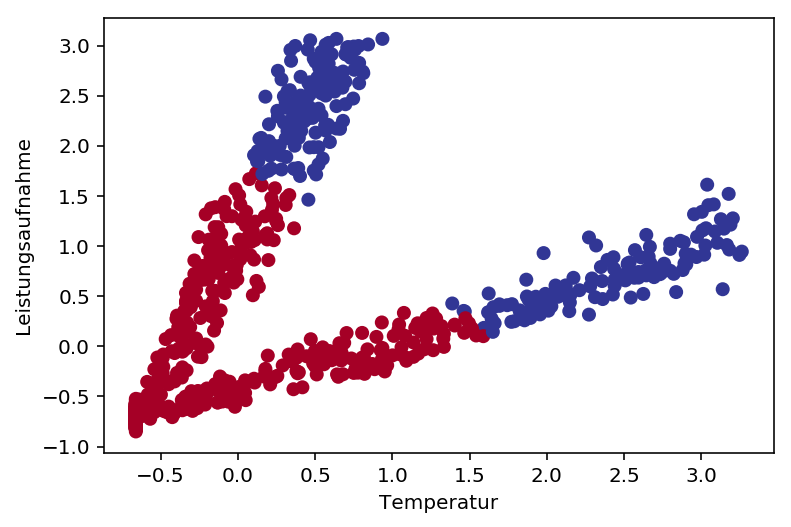

In [25]:
# Test-Modeldaten plotten, Farbwerte = vorhergesagte nA20 Werte
plt.scatter(X_test[:,0], X_test[:,1],c = y_predicted)
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()

In [26]:
# Anteil der korrekten Vorhersagen berechnen
model.score(X_test, y_test)

0.7313195548489666

In [27]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_predicted)

array([[728,  78],
       [260, 192]], dtype=int64)

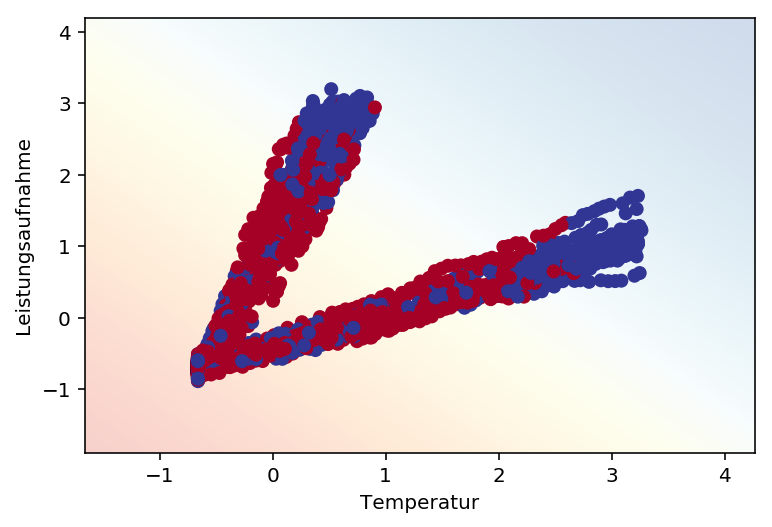

In [28]:
# Entscheidungsgrenze visualisieren
from helper import plot_classifier
plot_classifier(model, X_train, y_train, proba = True, xlabel = "Temperatur", ylabel = "Leistungsaufnahme")

In [29]:
# Predictions des/der zuletzt gelieferten Werte/s
p = df.tail(60)
p_data = p[["Temperatur", "Leistungsaufnahme"]].values
p_scaled = scaler.transform(p_data)

p_predicted = model.predict(p_scaled)

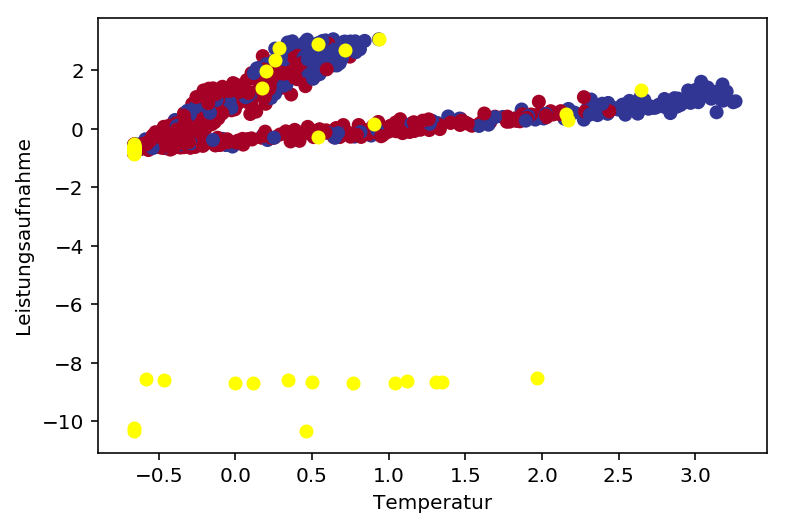

In [30]:
plt.scatter(X_test[:,0], X_test[:,1], c= y_test)
plt.scatter(p_scaled[:,0], p_scaled[:,1], c= "yellow")
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()

In [31]:

#kFold Cross Validation zur Bewertung des Models - mehrfache Durchführung
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
X = df_f[["Temperatur", "Leistungsaufnahme"]].values
y = df_f["nA20"].values
all_scores = []

kf = KFold(n_splits=10, shuffle=True)
for train_index, test_index in kf.split(X):
    X_test = X[test_index]
    X_train = X[train_index]
    y_test = y[test_index]
    y_train = y[train_index]
    model = LogisticRegression()
    model.fit(X_train, y_train)
    all_scores.append(round((model.score(X_test, y_test)),3))

print("Einzelergebnisse: " + str(all_scores))
Sum = sum(all_scores)
Med = round(Sum / len(all_scores),3)
print("Median der Einzelergebnisse: " + str(Med))


Einzelergebnisse: [0.726, 0.696, 0.708, 0.728, 0.72, 0.714, 0.728, 0.753, 0.726, 0.718]
Median der Einzelergebnisse: 0.722


In [32]:
#kFold Cross Validation zur Bewertung des Models - mehrfache Durchführung (Kurzschreibweise)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import numpy as np

scores = cross_val_score(LogisticRegression(), X, y, cv = KFold(n_splits=100,shuffle=True))

print("Median der Einzelergebnisse: " + str(round(np.mean(scores),3)))

Median der Einzelergebnisse: 0.722
